In [640]:
FROM_DATASET = True
N_SAMPLES = 10000
PARTITION = int(N_SAMPLES*0.1)
ITERS = 30
EPSILON = 1e-5

In [631]:
from sklearn.datasets import make_blobs, make_moons
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import collections
import scipy
import time
import math

In [632]:
#diabetes, Surgical-deepnet
DATABASE = 'Surgical-deepnet' 

In [643]:

if not FROM_DATASET:
    # Set random seed for reproducibility
    np.random.seed(420)

    # Create dataset with 10,000 points and 2 clusters
    #X, y = make_blobs(n_samples=N_SAMPLES, centers=2, cluster_std=1.5)
    X, y = make_moons(n_samples=N_SAMPLES, noise=0.2, random_state=420)
    y = np.where(y == 0, -1, y)

    # Print the shapes of X and y
    print("Shape of X:", X.shape)
    print("Shape of y:", y.shape)

    # Create scatter plot
    plt.scatter(X[:, 0], X[:, 1], c=y)

    # Add axis labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Scatter Plot of 10,000 Points with 2 Clusters')

    # Show the plot
    plt.show()

else:

    if DATABASE == "diabetes":
        data = np.genfromtxt('diabetes.csv', delimiter=',', skip_header=1)
        np.random.shuffle(data)
        X = data[:, :-1]
        y = data[:, -1]
        y = np.where(y == 0, -1, y)

        print("PCA")
        print("Shape 1: " +  str(X.shape))
        X = PCA(n_components=2).fit_transform(X)
        print("Shape 2: " +  str(X.shape))

    elif DATABASE == "Surgical-deepnet":
        data = np.genfromtxt('Surgical-deepnet.csv', delimiter=',', skip_header=1)
        np.random.shuffle(data)
        X = data[:, : -1]
        y = data[:, -1]
        y = np.where(y == 0, -1, y)

        print("PCA")
        print("Shape 1: " +  str(X.shape))
        X = PCA(n_components=5).fit_transform(X)
        print("Shape 2: " +  str(X.shape))
        X = X[:N_SAMPLES] 
        y = y[:N_SAMPLES] 


PCA
Shape 1: (14635, 24)
Shape 2: (14635, 5)


In [642]:
print("Dataset Lenght")
print("Tot: " + str(len(X)) + ", lab: " + str(PARTITION) + ", unlab: " + str(len(X)-PARTITION))

X.shape

Dataset Lenght
Tot: 10000, lab: 1000, unlab: 9000


(10000, 5)

In [635]:
# Points initialization
labeled_X = np.array(X[:PARTITION])
unlabeled_X = np.array(X[PARTITION:])

# Label initialization
labeled_y = np.array(y[:PARTITION])
target_y = np.array(y[PARTITION:])
initial_y = np.random.choice([-1,1], size = (len(unlabeled_X,)))

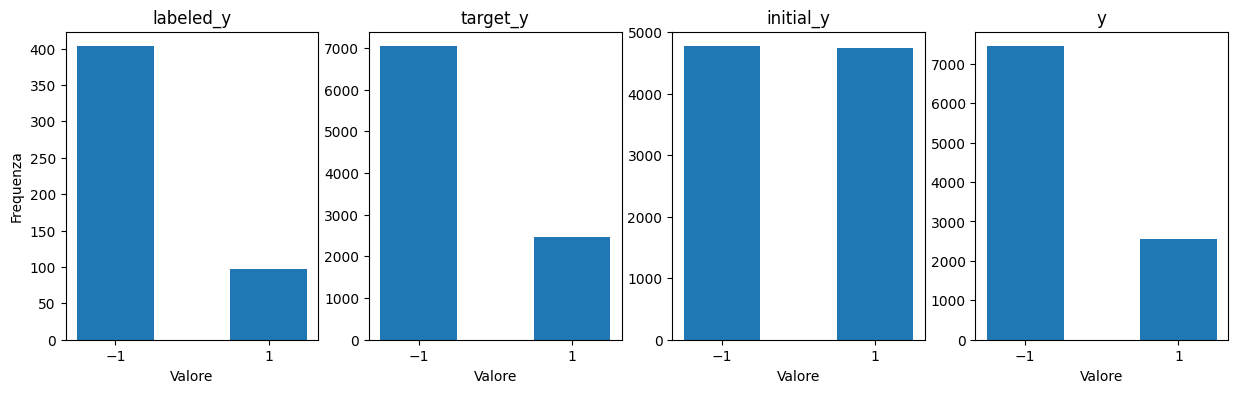

In [637]:
# Distribution
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

bin_edges = [-1.5, -0.5, 0.5, 1.5]

axs[0].hist(labeled_y, bins=bin_edges)
axs[1].hist(target_y, bins=bin_edges)
axs[2].hist(initial_y, bins=bin_edges)
axs[3].hist(y, bins=bin_edges)

for ax in axs:
    ax.set_xticks([-1, 1])
    ax.set_xlabel('Valore')

axs[0].set_ylabel('Frequenza')

axs[0].set_title('labeled_y')
axs[1].set_title('target_y')
axs[2].set_title('initial_y')
axs[3].set_title('y')

plt.show()

### Labeled-Unlabeled distances

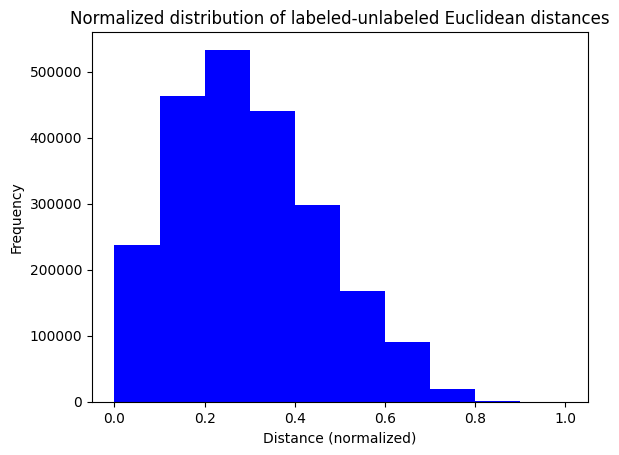

In [597]:

# Calculate distances
labeled_distances = cdist(labeled_X, unlabeled_X) 

# Normalize the distances
max_distance = np.max(labeled_distances)
labeled_normalized_distances = labeled_distances / max_distance

# Plot the normalized distribution of distances using a histogram
plt.hist(labeled_normalized_distances.flatten(), bins=10, color='blue')

# Set the x and y axis labels and title
plt.xlabel('Distance (normalized)')
plt.ylabel('Frequency')
plt.title('Normalized distribution of labeled-unlabeled Euclidean distances')

# Show the plot
plt.show()

### Unlabeled-Unlabeled distances

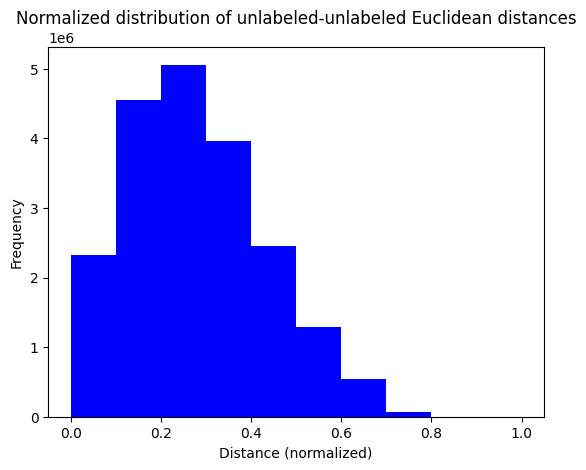

In [598]:
unlabeled_distances = cdist(unlabeled_X, unlabeled_X)

# Normalize the distances
max_distance = np.max(unlabeled_distances)
unlabeled_normalized_distances = unlabeled_distances / max_distance

# Plot the normalized distribution of distances using a histogram
plt.hist(unlabeled_normalized_distances.flatten(), bins=10, color='blue')

# Set the x and y axis labels and title
plt.xlabel('Distance (normalized)')
plt.ylabel('Frequency')
plt.title('Normalized distribution of unlabeled-unlabeled Euclidean distances')

# Show the plot
plt.show()


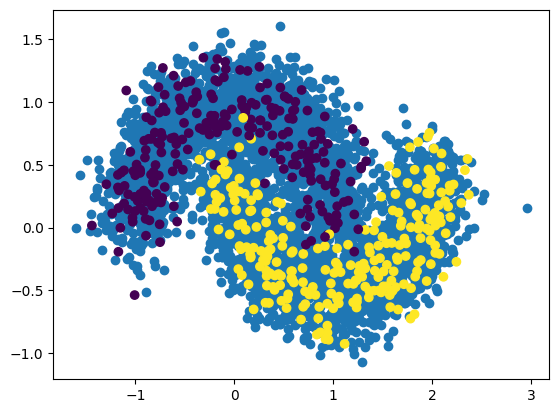

In [599]:
if not FROM_DATASET:
    plt.scatter(unlabeled_X[:, 0], unlabeled_X[:, 1])
    plt.scatter(labeled_X[:, 0], labeled_X[:, 1], c=labeled_y)
    plt.show()

## Calculating Weights

For the weights, the following is the function that has been choosen:

$$
weight(a,b) = e^{-100 ||a-b||^2_2}
$$

In [600]:
def weight(dist): 
    return math.e**(-100*dist**2)
    #return 1 / (1 + dist)

In [601]:
%%time
print("Computing weights")
labeled_unlabeled_weights = np.vectorize(weight)(labeled_normalized_distances)
unlabeled_unlabeled_weights = np.vectorize(weight)(unlabeled_normalized_distances)
print('Done')

Computing weights
Done
CPU times: user 10.2 s, sys: 1.93 s, total: 12.1 s
Wall time: 12.9 s


The following is the implementations of the loss function:
$$
f(y) = \sum_{i=0}^l\sum_{j=0}^u w_{ij}(y^j -\bar{y}^i)^2 + \frac{1}{2} \sum_{i=0}^u\sum_{j=0}^u \bar{w}_{ij}(y^j -y^i)^2
$$
the following function is using linear algebra and Numpy to calcolate it, in order to have decent performance

In [602]:
def loss(labeled, unlabeled):
    Y = np.copy(unlabeled).astype("float64").reshape((-1,1))
    Y_bar = np.copy(labeled).astype("float64").reshape((-1,1))

    labeled_unlabeled_loss = np.sum(np.power(Y - Y_bar.T, 2) * labeled_unlabeled_weights.T)
    unlabeled_unlabeled_loss = np.sum(np.power(Y - Y.T, 2) * unlabeled_unlabeled_weights.T)

    return labeled_unlabeled_loss + unlabeled_unlabeled_loss/2

The following is a function used to calcolate the accuracy

In [603]:
def accuracy(current):
    return np.sum(np.equal((current/2 + .5).round() * 2 - 1, target_y)) / len(target_y)

### Hessian and Lipschitz constant

Those functions are used to calculate the Hessian matrix and the Lipschitz constat for the whole problem, and for the single variable.
The Hessian is calculated as follows:


In [604]:
def hessian_matrix(unlabeled_unlabeled_w, labeled_unlabeled_w):
    matrix = np.copy(-unlabeled_unlabeled_w)
    
    for i in range(len(target_y)):
        matrix[i][i] = 2 * np.sum(labeled_unlabeled_w[:,i]) + np.sum(unlabeled_unlabeled_w[:,i]) - unlabeled_unlabeled_w[i][i]
    return matrix

def lipschitz_constant(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]
    
def is_strongly_convex(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(0,0))[0][0]


In [605]:
%%time
print("Hessian matrix")
hessian = hessian_matrix(unlabeled_unlabeled_weights, labeled_unlabeled_weights)

print("Calculating sigma (strongly convex)")
sigma = is_strongly_convex(hessian)
is_sc = sigma > 0

if is_sc: print(f"Sigma: {sigma}, strongly convex")
else: print(f"Sigma: {sigma}, not strongly convex")

L = lipschitz_constant(hessian)
print(f"Lipschitz constant: {L}")

print("Lipschitz constant for single variable")
Li = np.repeat(L, len(hessian))

Hessian matrix
Calculating sigma (strongly convex)
Sigma: 9.647334167819288, strongly convex
Lipschitz constant: 733.5584834734199
Lipschitz constant for single variable
CPU times: user 1min 13s, sys: 41.9 s, total: 1min 55s
Wall time: 19.8 s


## Gradient Descent Methods

Following is the function used to calculate the gradient, which for a single variable is:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = (2 \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})y^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$

Following are some constant that are going to be used in the gradient, we compute outside the gradient function avoiding usless computation

In [606]:
print("Computing constants of the gradient")

label_unlabel_tot = np.sum(labeled_unlabeled_weights, axis=0).reshape((-1,1))
unlabel_unlabel_tot = np.sum(unlabeled_unlabeled_weights, axis=0).reshape((-1,1))

first_constant = (2 * label_unlabel_tot) + unlabel_unlabel_tot
second_constant = 2 * np.multiply(
    labeled_y.reshape((-1,1)),
    labeled_unlabeled_weights
).sum(0).reshape((-1,1))

print("Done")

Computing constants of the gradient
Done


In [607]:
def gradient(unlabeled):
    unlabeled = unlabeled.reshape((-1,1))
    third_constant = np.multiply(
        unlabeled,
        unlabeled_unlabeled_weights
    ).sum(0).reshape((-1,1))
    return (first_constant * unlabeled - second_constant - third_constant).reshape((-1,))

### Gradient Descent

Creating a copy of the defined initialization, in order to have the same also in the following algorithms

In [608]:
y_unlabeled_gd = np.copy(initial_y)

In [609]:
%%time
ticks_gd = [0]
acc_gd = [accuracy(y_unlabeled_gd)]
loss_gd = [loss(labeled_y, y_unlabeled_gd)]
init_time = time.time() * 1000

for i in range(ITERS):
    if i % (ITERS * 0.1) == 0:
        print(f"{int(i/ITERS*100):02}%", end="")
    start = time.process_time()
    
    grad = gradient(y_unlabeled_gd)
    if EPSILON >= np.linalg.norm(grad): break # Condition
    y_unlabeled_gd = y_unlabeled_gd - 1/L * grad # Gradient Step
    
    acc_gd.append(accuracy(y_unlabeled_gd))
    loss_gd.append(loss(labeled_y, y_unlabeled_gd))
    ticks_gd.append(time.time() * 1000 - init_time)

    if i % (ITERS * 0.1) == 0:
        print(f" - acc {(acc_gd[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_gd):05.2f}")
        
print(f"""
Final accuracy: {round(acc_gd[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd))}
Loss: {loss(labeled_y, y_unlabeled_gd)}
""")

00% - acc 62.96% - loss 320415.09
10% - acc 92.51% - loss 154784.27
20% - acc 92.44% - loss 143679.86
30% - acc 92.02% - loss 141997.25
40% - acc 91.82% - loss 142278.72
50% - acc 91.71% - loss 142877.60
60% - acc 91.64% - loss 143394.36
70%

KeyboardInterrupt: 

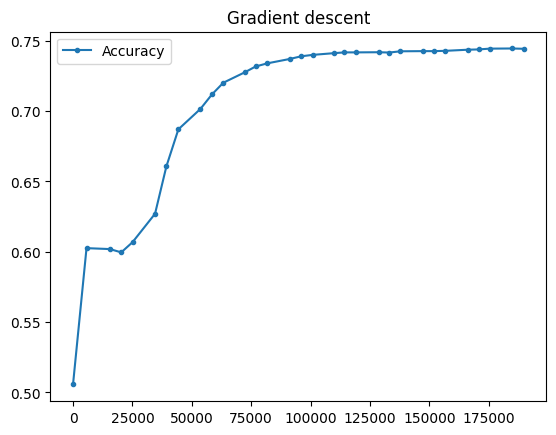

In [ ]:
plt.figure(dpi=100)
plt.title("Gradient descent")
plt.plot(ticks_gd, acc_gd, marker='.')
plt.legend(["Accuracy"])

### Gradient Descent with improved rate

This implementation of the GD algorithm with use:
$$
\alpha_k = $\frac{2}{L+sigma}$
$$
in case the problem is strongly convex

In [ ]:
y_unlabeled_gd_improved = np.copy(initial_y)

In [ ]:
%%time
ticks_gd_improved = [0]
acc_gd_improved = [accuracy(y_unlabeled_gd_improved)]
loss_gd_improved = [loss(labeled_y, y_unlabeled_gd_improved)]
init_time = time.time() * 1000

for i in range(ITERS):
    if i % (ITERS * 0.1) == 0 :
        print(f"{int(i/ITERS*100):02}%", end="")
    start = time.process_time()
    
    grad = gradient(y_unlabeled_gd_improved)
    if EPSILON >= np.linalg.norm(grad): break # Condition
    
    # Gradient Step
    if is_sc: y_unlabeled_gd_improved = y_unlabeled_gd_improved - (2 / (L + sigma)) * grad
    else: y_unlabeled_gd_improved = y_unlabeled_gd_improved - (1 / L) * grad

    acc_gd_improved.append(accuracy(y_unlabeled_gd_improved))
    loss_gd_improved.append(loss(labeled_y, y_unlabeled_gd_improved))
    ticks_gd_improved.append(time.time() * 1000 - init_time)

    if i % (ITERS * 0.1) == 0:
        print(f" - acc {(acc_gd_improved[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_gd_improved):05.2f}")
        
print(f"""
Final accuracy: {round(acc_gd_improved[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_improved))}
Loss: {loss(labeled_y, y_unlabeled_gd_improved)}
""")

00% - acc 50.76% - loss 4774663.30
10% - acc 61.16% - loss 3984657.27
20% - acc 64.04% - loss 3911672.27
30% - acc 64.49% - loss 3879996.77
40% - acc 64.59% - loss 3857735.55
50% - acc 64.73% - loss 3839425.63
60% - acc 64.69% - loss 3823168.59
70% - acc 64.83% - loss 3808078.12
80% - acc 64.77% - loss 3793689.58
90% - acc 64.94% - loss 3779743.86

Final accuracy: 64.96%
Norm gradient: 91975.69993680496
Loss: 3770615.9236189965

CPU times: user 2min 37s, sys: 34.9 s, total: 3min 12s
Wall time: 3min 18s


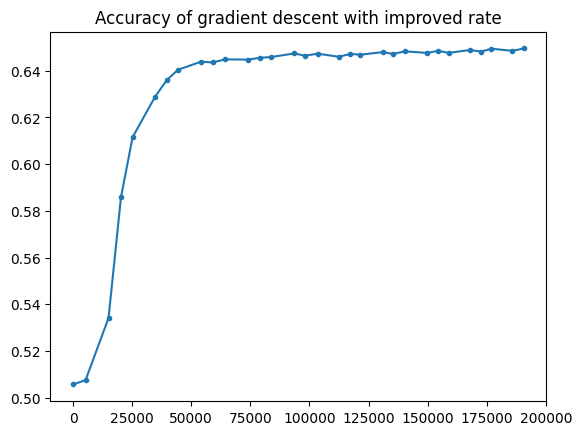

In [ ]:
plt.figure(dpi=100)
plt.title("Accuracy of gradient descent with improved rate")
plt.plot(ticks_gd_improved, acc_gd_improved, marker='.')

## Block Coordinate Gradient Method

Following is the function used to find the derivative in respect to a single variable:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = (2 \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})\bar{y}^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$

In [ ]:
def update_gradient(previous_grad, Li, index):
    global unlabeled_unlabeled_weights, first_constant
    step = 1/Li[index] * previous_grad[index]
    new_grad = np.copy(previous_grad)
    new_grad += unlabeled_unlabeled_weights[index] * step
    new_grad[index] -= first_constant[index] * step
    return step, new_grad

### Randomized

In [ ]:
y_unlabeled_bcgd_random = np.copy(initial_y).astype("float64")

In [ ]:
%%time
ticks_bcgd_random= [0]
acc_bcgd_random = [accuracy(y_unlabeled_bcgd_random)]
loss_bcgm_random = [loss(labeled_y, y_unlabeled_bcgd_random)]

previous_grad_random = gradient(y_unlabeled_bcgd_random)
max_iterations = ITERS*len(y_unlabeled_bcgd_random)
indexes = np.random.randint(0, len(y_unlabeled_bcgd_random), max_iterations)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * 0.1) == 0 :
        print(f"{int(i/max_iterations*100):02}%, end="")

    index = indexes[i]

    step, new_grad = update_gradient(previous_grad_random, Li, index)
    y_unlabeled_bcgd_random[index] = y_unlabeled_bcgd_random[index] - step
    previous_grad_random = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_random):
        break

    if (i+1) % len(target_y) == 0:

        acc_bcgd_random.append(accuracy(y_unlabeled_bcgd_random))
        loss_bcgm_random.append(loss(labeled_y, y_unlabeled_bcgd_random))
        ticks_bcgd_random.append(time.time() * 1000 - init_time)

    if i % (max_iterations * 0.1) == 0 :
        print(f" - acc {(acc_bcgd_random[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_bcgd_random):05.2f}")

print(f"""
Final accuracy: {round(acc_bcgd_random[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_random))}
Loss: {loss(labeled_y, y_unlabeled_bcgd_random)}
""")

00% - iter 0 / 270000 - final accuracy 50.57% - loss 8398140.71
10% - iter 27000 / 270000 - final accuracy 60.51% - loss 1673560.59
20% - iter 54000 / 270000 - final accuracy 66.01% - loss 706143.05
30% - iter 81000 / 270000 - final accuracy 70.24% - loss 487198.42
40% - iter 108000 / 270000 - final accuracy 72.52% - loss 419720.77
50% - iter 135000 / 270000 - final accuracy 73.57% - loss 391489.53
60% - iter 162000 / 270000 - final accuracy 74.03% - loss 377168.53
70% - iter 189000 / 270000 - final accuracy 74.11% - loss 368741.94
80% - iter 216000 / 270000 - final accuracy 74.23% - loss 363072.23
90% - iter 243000 / 270000 - final accuracy 74.31% - loss 359040.11

Final accuracy: 74.4%
Norm gradient: 1247.130143689972
Loss: 356060.62350394455

CPU times: user 2min 46s, sys: 35.4 s, total: 3min 22s
Wall time: 3min 31s


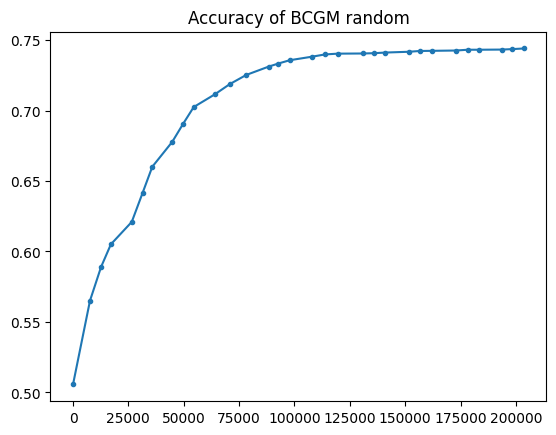

In [ ]:
plt.figure(dpi=100)
plt.title("Accuracy of BCGM random")
plt.plot(ticks_bcgd_random, acc_bcgd_random, marker='.')

### Gauss-Southwell

In [ ]:
y_unlabeled_bcgd_gs = np.copy(initial_y).astype("float64")

In [ ]:
%%time
ticks_bcgd_gs = [0]
acc_bcgd_gs = [accuracy(y_unlabeled_bcgd_gs)]
loss_bcgm_gs = [loss(labeled_y, y_unlabeled_bcgd_gs)]

max_iterations = ITERS*len(y_unlabeled_bcgd_random)
previous_grad_gs = gradient(y_unlabeled_bcgd_gs)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * 0.1) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = np.argmax(np.abs(previous_grad_gs))

    step, new_grad = update_gradient(previous_grad_gs, Li, index)
    y_unlabeled_bcgd_gs[index] = y_unlabeled_bcgd_gs[index] - step
    previous_grad_gs = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_gs): break # Condition

    if (i+1) % len(target_y) == 0:
        acc_bcgd_gs.append(accuracy(y_unlabeled_bcgd_gs))
        loss_bcgm_gs.append(loss(labeled_y, y_unlabeled_bcgd_gs))
        ticks_bcgd_gs.append(time.time() * 1000 - init_time)

    if i % (max_iterations * 0.1) == 0 :
        print(f" - final accuracy {(acc_bcgd_gs[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_bcgd_gs):05.2f}")

print(f"""
Final accuracy: {round(acc_bcgd_gs[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_gs))}
Loss: {loss(labeled_y, y_unlabeled_bcgd_gs)}
""")

00% - iter 0 / 270000 - final accuracy 50.57% - loss 8395699.45
10% - iter 27000 / 270000 - final accuracy 71.53% - loss 730323.62
20% - iter 54000 / 270000 - final accuracy 74.31% - loss 408150.41
30% - iter 81000 / 270000 - final accuracy 74.61% - loss 358101.01
40% - iter 108000 / 270000 - final accuracy 74.72% - loss 348274.53
50% - iter 135000 / 270000 - final accuracy 74.71% - loss 345864.86
60% - iter 162000 / 270000 - final accuracy 74.77% - loss 345149.38
70% - iter 189000 / 270000 - final accuracy 74.76% - loss 344915.33
80% - iter 216000 / 270000 - final accuracy 74.77% - loss 344830.66
90% - iter 243000 / 270000 - final accuracy 74.77% - loss 344797.43

Final accuracy: 74.77%
Norm gradient: 33.27034542298776
Loss: 344782.6858906585

CPU times: user 2min 53s, sys: 42.1 s, total: 3min 35s
Wall time: 3min 52s


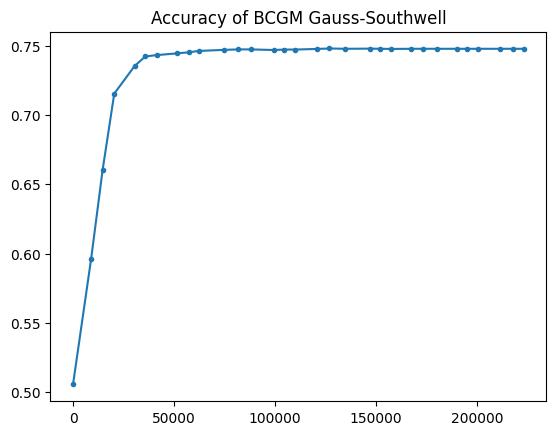

In [ ]:
plt.figure(dpi=100)
plt.title("Accuracy of BCGM Gauss-Southwell")
plt.plot(ticks_bcgd_gs, acc_bcgd_gs, marker='.')

### Loss

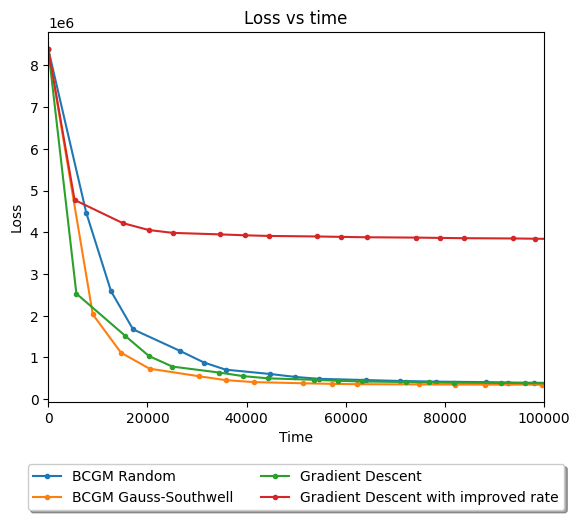

In [ ]:
plt.figure(dpi=100)
plt.plot(ticks_bcgd_random , loss_bcgm_random, marker='.')
plt.plot(ticks_bcgd_gs , loss_bcgm_gs, marker='.')
plt.plot(ticks_gd , loss_gd, marker='.')
plt.plot(ticks_gd_improved , loss_gd_improved, marker='.')


plt.title("Loss vs time")
plt.xlabel("Time")
plt.ylabel("Loss")
plt.xlim(-10,100000)
plt.legend(
    [
        'BCGM Random',
        'BCGM Gauss-Southwell',
        'Gradient Descent',
        'Gradient Descent with improved rate',
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2

)

## Accurancy

### Only BCGM compared

In [ ]:
min_acc = np.min(np.concatenate((acc_bcgd_random, acc_bcgd_gs)))
max_acc = np.max(np.concatenate((acc_bcgd_random, acc_bcgd_gs)))

min_y_plot = max(min_acc - .1 * (1 - min_acc), 0.5)
max_y_plot = max_acc + (.1 * (1 - max_acc))

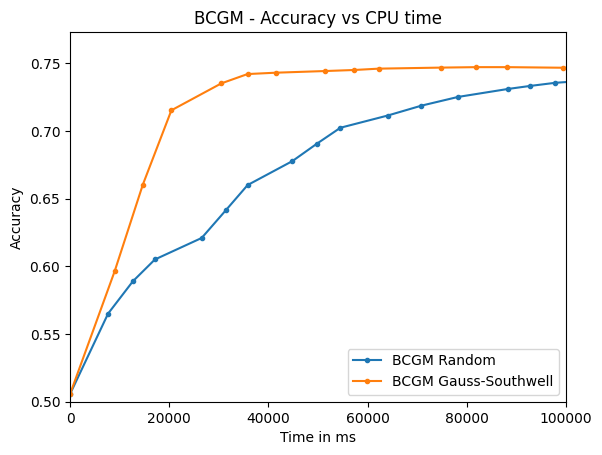

In [ ]:
plt.figure(dpi=100)
plt.axhline(y=1, color='red', linestyle='dashed', lw=1, label='_nolegend_')
plt.ylim(min_y_plot, max_y_plot)
plt.plot(ticks_bcgd_random, acc_bcgd_random, marker='.')
plt.plot(ticks_bcgd_gs, acc_bcgd_gs, marker='.')

plt.title("BCGM - Accuracy vs CPU time")
plt.xlabel("Time in ms")
plt.ylabel("Accuracy")
plt.xlim(-10,100000)
plt.legend(
    ['BCGM Random', 'BCGM Gauss-Southwell'],
    loc="lower right"
)

### Only Gradient Descent Compared

In [ ]:
min_acc = np.min(np.concatenate((acc_gd, acc_gd_improved)))
max_acc = np.max(np.concatenate((acc_gd, acc_gd_improved)))

min_y_plot = max(min_acc - .1 * (1 - min_acc), 0.5)
max_y_plot = max_acc + (.1 * (1 - max_acc))

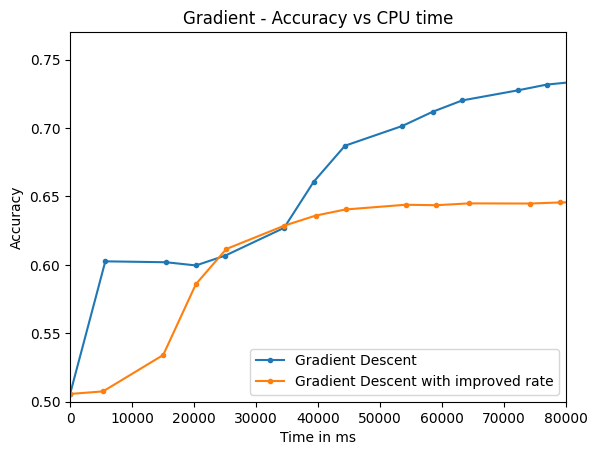

In [ ]:
plt.figure(dpi=100)
plt.axhline(y=1, color='red', linestyle='dashed', lw=1, label='_nolegend_')
plt.ylim(min_y_plot, max_y_plot)
plt.plot(ticks_gd, acc_gd, marker='.')
plt.plot(ticks_gd_improved, acc_gd_improved, marker='.')

plt.title("Gradient - Accuracy vs CPU time")
plt.xlabel("Time in ms")
plt.ylabel("Accuracy")
plt.xlim(-10,80000)
plt.legend(
    ['Gradient Descent', 'Gradient Descent with improved rate'],
    loc="lower right"
)